In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from ipywidgets import interact
import ipywidgets as widgets
import stlabutils
import matplotlib.colors as colors

First, let's find a good way to get the data and metadata in:

In [2]:
#folder = "data_for_offline/"

In [3]:
folder = "/home/jovyan"
folder += "/steelelab/measurement_data/newBF/Sarwan/20191130_LERA8A9_NC1NC2/"
folder += "LERA8_NC1/OMIT/OT8_2019_12_02_18.42.35_two_tone_spec_bigger_span/"

In [4]:
dat_file = glob(folder+"*.dat")[0]
meta_file = glob(folder+"*.meta.txt")[0]

In [5]:
with open(meta_file) as f:
    metadata = f.read()
metadata = metadata.splitlines()

In [6]:
for l,n in zip(metadata,range(len(metadata))):
    print("%d\t%s" % (n,l))

0	#Inner loop, X
1	10001
2	5269060000.0
3	5270060000.0
4	Probe Frequency (Hz)
5	#Outer loop, Y
6	25
7	18.0
8	-30.0
9	Pump Frequency (Hz)
10	#No loop, Z
11	1
12	0
13	1
14	Nothing
15	#Column labels
16	1
17	Frequency (Hz)
18	2
19	S21re ()
20	3
21	S21im ()
22	4
23	S21dB (dB)
24	5
25	S21Ph (rad)
26	6
27	Power (dBm)


In [7]:
loop_dim = []
for i in range(3):
    loop_dim.append(int(metadata[1+i*5]))
print(loop_dim)

loop_start = []
for i in range(3):
    loop_start.append(float(metadata[2+i*5]))
print(loop_start)

loop_stop = []
for i in range(3):
    loop_stop.append(float(metadata[3+i*5]))
print(loop_start)

loop_name = []
for i in range(3):
    loop_name.append(metadata[4+i*5])
print(loop_name)

[10001, 25, 1]
[5269060000.0, 18.0, 0.0]
[5269060000.0, 18.0, 0.0]
['Probe Frequency (Hz)', 'Pump Frequency (Hz)', 'Nothing']


In [8]:
column_name = {}
for i in range(16,len(metadata),2):
    col_num = int(metadata[i])-1
    col_name = metadata[i+1]
    column_name[col_num] = col_name
print(column_name)

{0: 'Frequency (Hz)', 1: 'S21re ()', 2: 'S21im ()', 3: 'S21dB (dB)', 4: 'S21Ph (rad)', 5: 'Power (dBm)'}


OK, I think we've got the metadata in a good way! Let's load the data. Let's keep things simple and use numpy.

In [9]:
data = np.loadtxt(dat_file,delimiter=',')

In [10]:
data.shape

(250025, 6)

Our files are stored in "Fortran" order apparently

In [11]:
datacube = data.reshape(loop_dim[0], loop_dim[1], loop_dim[2], data.shape[1],order='F')
datacube.shape

(10001, 25, 1, 6)

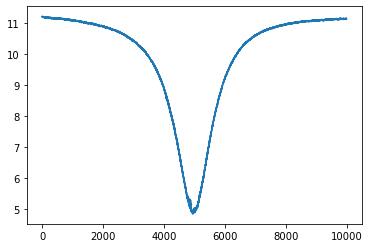

In [12]:
plt.plot(datacube[:,0,0,3])

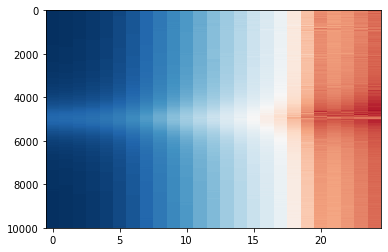

In [13]:
plt.imshow(datacube[:,:,0,3], aspect='auto',cmap='RdBu')

Good! Now let's add axis labels. Start with the line cuts, they are easy. I will make an example function, simplified for this dataset since loop2 is only dimension 1 (as is likely the case for most of our datasets). And hardcoded for now with column 3 (dB).

In [14]:
def plot_linecut(index):
    x = np.linspace(loop_start[0], loop_stop[0], loop_dim[0])
    y = datacube[:,index,0,3]
    index_val = loop_start[1] + index/loop_dim[1]*(loop_stop[1]-loop_start[1])
    plt.plot(x,y)
    plt.xlabel(loop_name[0])
    plt.ylabel(column_name[3])
    plt.title("%s = %e" % (loop_name[1], index_val))

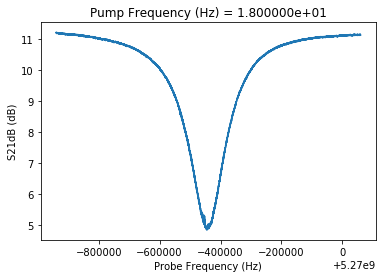

In [15]:
plot_linecut(0)

OK, not bad. Unfortunately, Sarwan and Adrian have not updated the values of the loop range properly in the  metafile! So all of this work is for NOTHING! Topic for group meeting next week: Make sure everyone know how to use meta file creation routines, and make sure they implement them in all their code!

In the meantime, let's make a nice fast interactive version of this.

In [16]:
# For turning notebook driver off
%matplotlib inline

I don't know why, but the notebook driver has some bug where it flashes and then fails to display the plot properly unless you run this twice.

In [17]:
%matplotlib notebook

In [18]:
%matplotlib notebook

# Interactive linecut explorer

A nice interactive widget!

In [19]:
def interactive_linecut(direction = 'x'):
    if direction == 'x':
        n=0; m=1
    else:
        n=1; m=0
    line, = plt.plot((0,1),(0,1))
    autoscale_types = {1 : "both", 2: "x", 3: "y"}
    autoscale_labels = [("Full dataset range", 0), ("Both",1), 
                        ("X (full trace)",2), ("Y (full trace)", 3), ("Off (keep zoom)",4)]
    x = np.linspace(loop_start[0], loop_stop[0], loop_dim[0])

    def update(index=0, col=3, autoscale = 1):
        plt.ylabel(column_name[col])
        y = datacube[:,index,0,col]
        line.set_data(x,y)
        if autoscale:
            if autoscale != 4:
                plt.autoscale(axis=autoscale_types[autoscale])
                plt.gca().relim()
                plt.gca().autoscale_view()
        else:
            plt.autoscale(axis='x')
            plt.gca().relim()
            plt.gca().autoscale_view()
            min_y = np.min(datacube[:,:,0,col])
            max_y = np.max(datacube[:,:,0,col])
            span = max_y - min_y
            if span == 0: 
                span = 1e-9
            plt.ylim(min_y - 0.05*span, max_y + 0.05*span)
        index_val = loop_start[1] + index/loop_dim[1]*(loop_stop[1]-loop_start[1])
        plt.title("%s = %e" % (loop_name[1], index_val))

    interact(update,index=(0,loop_dim[1]-1), 
             col = (0,len(column_name)-1), 
             autoscale = autoscale_labels)

<IPython.core.display.Javascript object>


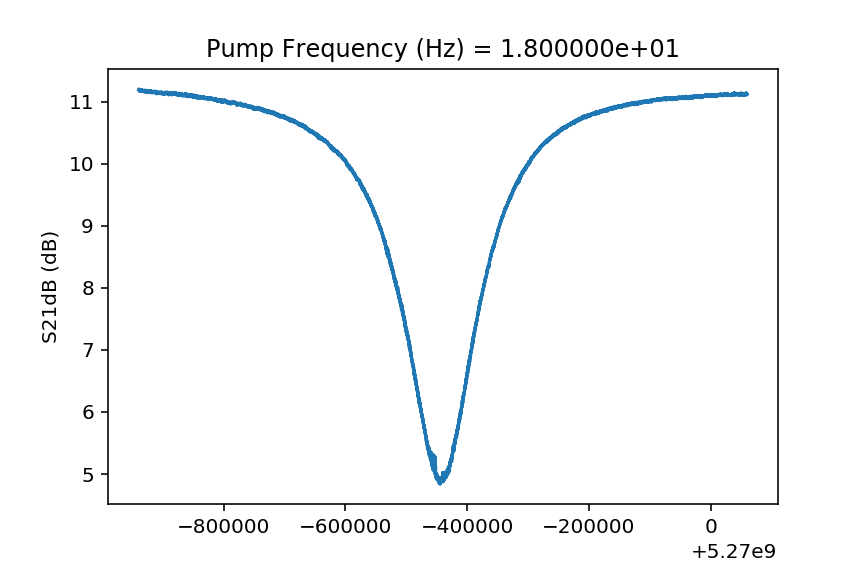

interactive(children=(IntSlider(value=0, description='index', max=24), IntSlider(value=3, description='col', m…

In [20]:
interactive_linecut()

# Interactive colorscale plots

Now let's try an interactive colorplot.

In [21]:
# try feeding it into one of Marks mtx objects? first via pandas?
xvals = np.linspace(loop_start[0], loop_stop[0], loop_dim[0])
yvals = np.linspace(loop_start[1], loop_stop[1], loop_dim[1])
df = pd.DataFrame(np.flip(datacube[:,:,0,3].T,axis=0),columns=xvals, index=yvals)
mtx = stlabutils.utils.stlabdict.stlabmtx(df, xtitle=loop_name[0], ytitle=loop_name[1], ztitle=column_name[3])
mtx.sub_lbl()

(25, 10001)


In [22]:
mtx.processlist

['sub_lbl 40,40,-1e+99,1e+99']

This is not a bad start!

In [25]:
foo = "help(mtx.sub_lbl)"
eval(foo)

Help on method sub_lbl in module stlabutils.utils.stlabdict:

sub_lbl(lowp=40, highp=40, low_limit=-1e+99, high_limit=1e+99) method of stlabutils.utils.stlabdict.stlabmtx instance
    Substract line by line filter
    
    The average value of each line is substracted from the data.  Parts of each line cut can be
    excluded using the high and low percentile options.  The idea is that all points are sorted in
    increasing order and a percentage from the back and front of the list is rejected for the average
    calculation.  Process string :code:`sub_lbl lowp,highp,low_limit,high_limit`
    
    Parameters
    ----------
    lowp : float
        Percentage of points to be rejected from the averaging on the low side.
    highp : float
        Percentage of points to be rejected from the averaging on the high side.
    low_limit : float
        Absolute value below which points are ignored for the average (and percentile calculations)
    low_limit : float
        Absolute value above

In [43]:
# from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

def truncate_colormap(minval=0.0, maxval=1.0, cmapIn='RdBu_r'):
    cmapIn = plt.get_cmap(cmapIn)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, 256)))
    return new_cmap

<IPython.core.display.Javascript object>


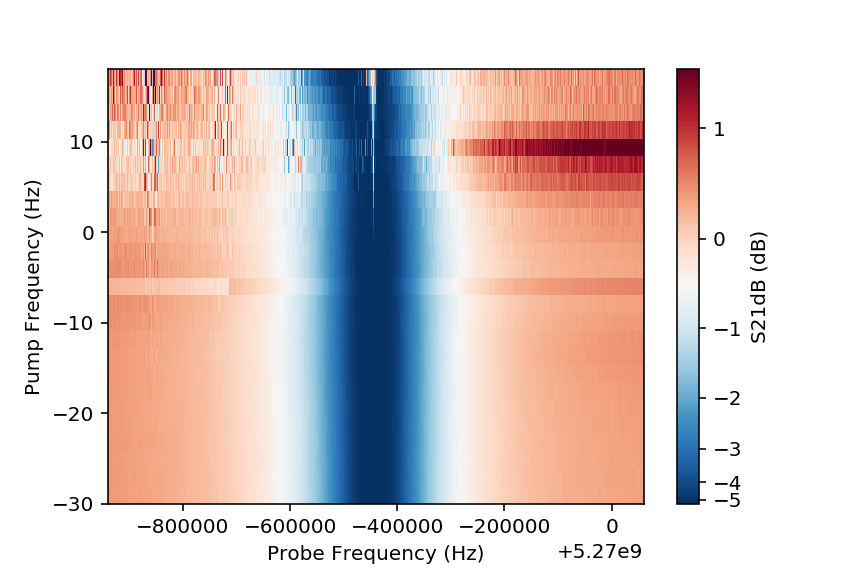

interactive(children=(FloatLogSlider(value=1.0, description='gamma', max=1.0, min=-1.0, readout_format='.2f', …

<function __main__.update(gamma=1, min_quantile=0.02, max_quantile=0.98, cmap_min=0, cmap_max=1)>

In [44]:
gamma = 0.5
ext = [loop_start]
img = plt.imshow(mtx.pmtx, extent=mtx.getextents(), 
           norm=colors.PowerNorm(gamma=gamma),
           aspect='auto',cmap='RdBu_r')
plt.xlabel(mtx.xtitle)
plt.ylabel(mtx.ytitle)
plt.colorbar().set_label(mtx.ztitle)

vmin = mtx.pmtx.quantile(0.02).quantile(0.02)
vmax = mtx.pmtx.quantile(0.98).quantile(0.98)
plt.clim(vmin,vmax)

def update(gamma=1, min_quantile=0.02, max_quantile = 0.98,
          cmap_min = 0, cmap_max = 1):
    img.set_cmap(truncate_colormap(cmap_min, cmap_max))
    vmin = mtx.pmtx.quantile(min_quantile).quantile(min_quantile)
    vmax = mtx.pmtx.quantile(max_quantile).quantile(max_quantile)
    img.set_norm(norm=colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax))

interact(update,
         gamma=widgets.FloatLogSlider(
             base=10, min=-1, max = 1, step = 0.05, readout_format = ".2f"),
         min_quantile=widgets.FloatSlider(
             value = 0.02, min=0, max=1, step=0.001,readout_format = ".3f"),
         max_quantile=widgets.FloatSlider(
             value = 0.98, min=0, max=1, step=0.001,readout_format = ".3f"),
         cmap_min = (0,1,0.01), 
         cmap_max = (0,1,0.01)
        )


## Feature request

Plot two datasets  in line cuts, very useful for plotting theory on top of experiment

Display boxes with processing options